In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import ali.methods
import ali.ui
from sklearn.preprocessing import StandardScaler 
import compress_pickle

In [5]:
def selectTrainTestSet(rhr, info,train_days=100,test_days=14):
    if info['covid_test_date']:
        dates_s = rhr.loc[(rhr.index < info['covid_test_date'] - pd.to_timedelta(f'{test_days}d'))].index.floor('1D').unique()
        dates_e = list(rhr.loc[(rhr.index > info['covid_test_date'] + pd.to_timedelta(f'{test_days}d'))].index.floor('1D').unique())
    else:
        dates_s = rhr.index.floor('1D').unique()
        dates_e = []

    dates_s=dates_s.insert(0,rhr.index[0])
    dates_e.append(rhr.index[-1])

    s = min(train_days, len(dates_s)-1)
    e = -min(max(0,train_days-s), len(dates_e)-1)
    train = rhr.loc[(rhr.index < dates_s[s]) | (rhr.index > dates_e[e])]
    test = rhr.loc[(rhr.index >= dates_s[s]) & (rhr.index <= dates_e[e])]
    
    return train, test


def preprocessing(train, test=None,force=True):
    if (not force) and os.path.isfile(f'ali/an_data/preprocess.pkl.lz4'):
        scaler = compress_pickle.load(f'ali/an_data/preprocess.pkl.lz4')
    else:
        scaler = StandardScaler()
        scaler = scaler.fit(train[['heartrate']])
        compress_pickle.dump(scaler, f'ali/an_data/preprocess.pkl.lz4')

    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    if test is not None:
        test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
    return train, test

875

In [11]:
resolution='1T'
alltest=pd.DataFrame()
alltrain=pd.DataFrame()

dirs=os.listdir('output/my')
for i,id in enumerate(dirs):

    if not "P" in id :continue
        
    print(f'{i/len(dirs)*100:.0f}%',end='\r')
    hr,step,rhr,info=ali.methods.load(id)
    if len(rhr)==0:continue
#     if info['covid_test_date']:
    rhr1=rhr.resample(resolution).mean().dropna()
    rhr1['id']=id
    train,test=selectTrainTestSet(rhr1,info,train_days=30)
    alltrain=pd.concat([alltrain,train])
    alltest=pd.concat([alltest,test])
    
alltrain=alltrain.astype(np.float16)
alltest=alltest.astype(np.float16)

In [13]:
alltrain=alltrain.reset_index().set_index(['id','datetime'])
alltrain.to_hdf('all-train.h5','train')

alltest=alltest.reset_index().set_index(['id','datetime'])
alltest.to_hdf('all-test.h5','test')

In [24]:
alltrainp,alltestp=preprocessing(alltrain,alltest,force=True)
alltrainp.to_hdf('all-trainp.h5','trainp')
alltestp.to_hdf('all-testp.h5','testp')

In [3]:
alltrainp=pd.read_hdf('all-trainp.h5',key='trainp')
alltestp=pd.read_hdf('all-testp.h5',key='testp')

In [20]:
def create_sequences(data, seg,min_data_count=200):
    seqs=[]
    
    allp2=data.reset_index(level=[0]).groupby('id').resample('1T').mean()
#     display(allp2)
    allp2['date'] = allp2.index.get_level_values(1).floor('1D')
    allp2['time'] = allp2.index.get_level_values(1).time
    day_time = allp2.set_index(['time', 'date']).astype(np.float64).unstack(level=1).droplevel(0, axis=1)
    day_time_info=day_time.notnull().sum(axis=1)
    day_time_info.hist()
    day_time2=day_time.loc[day_time.notnull().sum(axis=1)>min_data_count]
    ids=day_time2.index.get_level_values(0).unique()
    
    day_time2 = day_time2.interpolate(limit_direction='both', axis=1).astype(np.float16)
    display(day_time2)
    n=0
    shape=None
    for id in ids:
        for w in day_time2.loc[id].rolling(window=f'{seg}D', closed='right'): 
            if len(w)==seg:
                n+=1
                shape=w.values.shape
    print(f'n={n} ids={len(ids)} shape={shape}')        
    out=np.zeros((n,shape[0]*shape[1],1),np.float16)
    i=0
    for id in ids:
      for w in day_time2.loc[id].rolling(window=f'{seg}D', closed='right'): 
        if len(w)==seg:
            out[i,:,:]=(np.reshape(w.values, (shape[0]*shape[1],1)))
            i+=1
    return out

In [21]:
create_sequences(alltrainp,seg=3)

ValueError: Index contains duplicate entries, cannot reshape

In [12]:
import numpy as np
import pandas as pd
import datetime as DT

def using_Grouper(df):
    level_values = df.index.get_level_values
    return (df.groupby([level_values(i) for i in [0,1]]
                       +[pd.Grouper(freq='2D', level=-1)]).sum())

def using_reset_index(df):
    df = df.reset_index(level=[0, 1])
    display(df)
    return df.groupby(['State','City']).resample('2D').sum()

def using_stack(df):
    # http://stackoverflow.com/a/15813787/190597
    return (df.unstack(level=[0,1])
              .resample('2D').sum()
              .stack(level=[2,1])
              .swaplevel(2,0))

def make_orig():
    values_a = range(16)
    values_b = range(10, 26)
    states = ['Georgia']*8 + ['Alabama']*8
    cities = ['Atlanta']*4 + ['Savanna']*4 + ['Mobile']*4 + ['Montgomery']*4
    dates = pd.DatetimeIndex([DT.date(2012,1,1)+DT.timedelta(days = i) for i in range(4)]*4)
    df = pd.DataFrame(
        {'value_a': values_a, 'value_b': values_b},
        index = [states, cities, dates])
    df.index.names = ['State', 'City', 'Date']
    return df

def make_df(N):
    dates = pd.date_range('2000-1-1', periods=N)
    states = np.arange(50)
    cities = np.arange(10)
    index = pd.MultiIndex.from_product([states, cities, dates], 
                                       names=['State', 'City', 'Date'])
    df = pd.DataFrame(np.random.randint(10, size=(len(index),2)), index=index,
                      columns=['value_a', 'value_b'])
    return df

df = make_orig()
# display(df)
print(using_reset_index(df))

,State,City,value_a,value_b
Date,,,,
2012-01-01,Georgia,Atlanta,0,10
2012-01-02,Georgia,Atlanta,1,11
2012-01-03,Georgia,Atlanta,2,12
2012-01-04,Georgia,Atlanta,3,13
2012-01-01,Georgia,Savanna,4,14
2012-01-02,Georgia,Savanna,5,15
2012-01-03,Georgia,Savanna,6,16
2012-01-04,Georgia,Savanna,7,17
2012-01-01,Alabama,Mobile,8,18


                               value_a  value_b
State   City       Date                        
Alabama Mobile     2012-01-01       17       37
                   2012-01-03       21       41
        Montgomery 2012-01-01       25       45
                   2012-01-03       29       49
Georgia Atlanta    2012-01-01        1       21
                   2012-01-03        5       25
        Savanna    2012-01-01        9       29
                   2012-01-03       13       33


In [14]:
x_train=create_sequences(alltrainp,seg=3,min_data_count=200)
# import h5py
# with h5py.File('/workspace/ssd2/x_train.h5', 'w') as f:
#     f.create_dataset('x_train',data=x_train)

#x_train.to_hdf('x_train.h5','x_train')
#x_train=pd.read_hdf('x_train.h5','x_train')


# x_test.to_hdf('x_test.h5','x_test')
# x_test=pd.read_hdf('x_test.h5','x_test')

KeyError: "None of ['id'] are in the columns"

In [25]:
    x_train=h5py.File('/workspace/ssd2/x_train.h5','r')['x_train'][:]

In [27]:
x_train.shape

(921910, 1260, 1)

time                00:00:00  00:01:00  00:02:00  00:03:00  00:04:00  \
id      date                                                           
P100300 2027-07-23 -1.032227 -1.228516 -1.724609 -1.285156 -1.505859   
        2027-07-24 -1.708984 -1.640625 -1.583984 -1.491211 -1.425781   
        2027-07-25 -1.099609 -0.470947 -0.899902 -0.756836 -0.743164   
        2027-07-26 -0.788574 -0.714844 -0.714844 -0.613770 -0.871094   
        2027-07-27 -1.075195 -1.135742 -1.245117 -1.089844 -0.705566   
...                      ...       ...       ...       ...       ...   
P992022 2024-12-02 -0.534668 -0.462402 -0.580078 -0.567871 -0.546387   
        2024-12-03 -0.761719 -1.017578 -1.135742 -1.135742 -1.159180   
        2024-12-04  0.967773  0.894043  0.925781  0.511230  0.751465   
        2024-12-05 -0.515137 -0.583984 -0.687012 -0.883301 -0.785156   
        2024-12-06 -1.019531 -0.830566 -0.919434 -0.895020 -0.647461   

time                00:05:00  00:06:00  00:07:00  00:08:00  00:09:00  ...  \
id      date                                                          ...   
P100300 2027-07-23 -1.557617 -1.608398 -1.575195 -1.586914 -1.627930  ...   
        2027-07-24 -1.693359 -1.623047 -1.543945 -1.493164 -1.278320  ...   
        2027-07-25 -0.871094 -0.817871 -1.002930 -1.146484 -0.869141  ...   
        2027-07-26 -0.683105 -0.277344 -0.190430 -0.103577 -0.016617  ...   
        2027-07-27 -1.201172 -0.967285 -0.780273 -0.765137 -0.871094  ...   
...                      ...       ...       ...       ...       ...  ...   
P992022 2024-12-02 -0.560547 -0.546387 -0.681152 -0.700684 -0.785156  ...   
        2024-12-03 -1.103516 -1.177734 -1.171875 -0.956543 -0.967285  ...   
        2024-12-04  0.852051  0.873047  0.757324  0.715332  0.955566  ...   
        2024-12-05 -0.738770 -0.735840 -0.746582 -0.672852 -0.790527  ...   
        2024-12-06 -0.641113 -0.693848 -0.827148 -0.714844 -0.687012  ...   

time                06:50:00  06:51:00  06:52:00  06:53:00  06:54:00  \
id      date                                                           
P100300 2027-07-23 -0.210083 -0.210083 -0.210083 -0.210083 -0.210083   
        2027-07-24 -0.077881 -0.426514 -0.260498 -0.094421 -0.518555   
        2027-07-25 -1.219727 -0.857910 -1.409180 -1.374023 -1.367188   
        2027-07-26 -1.917969 -1.850586 -1.659180 -1.752930 -1.532227   
        2027-07-27 -0.811035 -1.387695 -1.159180 -1.149414 -1.278320   
...                      ...       ...       ...       ...       ...   
P992022 2024-12-02  1.192383  0.886719  0.581543  0.275879  0.168457   
        2024-12-03 -0.311035 -0.157593 -0.277344 -0.395264 -0.443848   
        2024-12-04 -0.967285 -0.883301 -0.883301 -0.854980 -1.039062   
        2024-12-05  0.210571 -0.110229 -0.430908 -0.706543 -0.904297   
        2024-12-06 -1.171875 -1.117188 -0.985840 -1.051758 -0.920410   

time                06:55:00  06:56:00  06:57:00  06:58:00  06:59:00  
id      date                                                          
P100300 2027-07-23 -0.210083 -0.210083 -0.210083 -0.210083 -0.210083  
        2027-07-24 -0.415771 -0.312988 -0.210083 -0.273193 -0.325684  
        2027-07-25 -1.177734 -1.143555 -1.163086 -1.303711 -1.319336  
        2027-07-26 -1.750000 -0.706543 -1.556641 -1.376953 -1.486328  
        2027-07-27 -0.872559 -0.588867 -0.735840 -0.883301 -0.967285  
...                      ...       ...       ...       ...       ...  
P992022 2024-12-02  0.406738  0.474854  0.305176  0.510254  0.715332  
        2024-12-03 -0.408936 -0.234131  0.000209 -0.515137 -0.218506  
        2024-12-04 -0.844727 -0.798828 -0.985840 -0.975586 -0.967285  
        2024-12-05 -0.935547 -0.827148 -0.668945 -0.899902 -0.925293  
        2024-12-06 -0.454102 -0.787109 -0.992676 -0.798828 -1.000977  

[99756 rows x 420 columns]

n=11812180 ids=99756 shape=(3, 420)


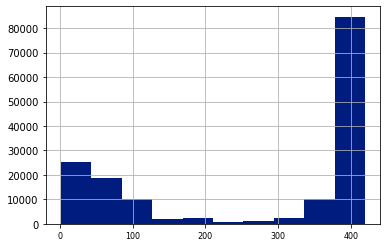

In [9]:
import h5py
x_test=create_sequences(alltestp,seg=3,min_data_count=200)
with h5py.File('/workspace/ssd2/x_test.h5', 'w') as f:
     f.create_dataset('x_test',data=x_test)
    
    

In [12]:
print('a')

a


In [14]:
def createAutoEncoderModel(shape):
    model = keras.Sequential(
        [
            layers.Input(shape=(shape[1], shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    return model


In [ ]:
model = createAutoEncoderModel(x_train.shape)

model.summary()
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)
model.save(f'ali/an_data/model-all-{seg}.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 630, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 630, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 315, 16)           3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 630, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 630, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 1260, 32)         3616      
 ranspose)                                            

In [39]:
x_train_pred = model.predict(x_train).astype(np.float16)


In [49]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                train_mae_loss:  1.8 MiB
                           _i5:  1.4 KiB
                           _i7:  1.2 KiB
                StandardScaler:  1.0 KiB
                          _i14:  987.0 B
               NamespaceMagics:  896.0 B
                          _i34:  587.0 B
                          _i37:  587.0 B
                           _ii:  562.0 B
                          _i42:  562.0 B


In [54]:
model.save(f'model-all-{seg}.h5')

In [57]:
import h5py
with h5py.File('/workspace/ssd2/train_mae_loss.h5', 'w') as f:
    f.create_dataset('train_mae_loss',data=train_mae_loss)


In [2]:
seg=3
model=keras.models.load_model(f'ali/an_data/model-all-{seg}.h5')

In [16]:
del x_test2
import gc
gc.collect()

NameError: name 'x_test2' is not defined

In [3]:
import h5py

x_test2=h5py.File('/workspace/ssd2/x_test.h5','r')['x_test'][0:1000000]

In [5]:
train_mae_loss=h5py.File('/workspace/ssd2/train_mae_loss.h5','r')['train_mae_loss'][:]

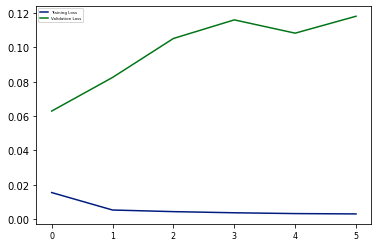

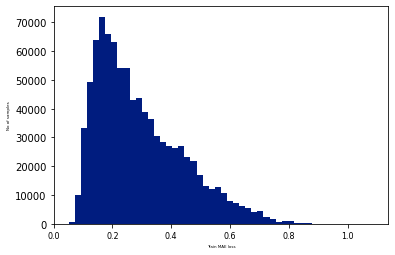

In [40]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Get train MAE loss.
# x_train_pred = model.predict(x_train).astype(np.float16)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

Reconstruction error threshold:  1.086


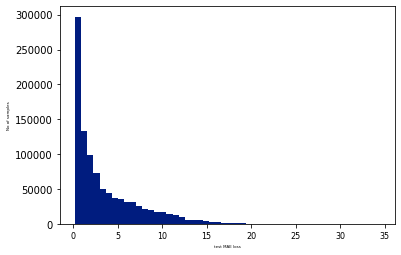

Number of anomaly samples:  666397
Indices of anomaly samples:  (array([     4,     13,     14, ..., 999997, 999998, 999999]),)


In [6]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

# fig, ax = plt.subplots()
# test.plot(legend=False, ax=ax)
# plt.show()
x_test=x_test2[0:1000000]
# Create sequences from test values.
# x_test = create_sequences(testp, seg=seg, resolution=resolution)
# print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test).astype(np.float16)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


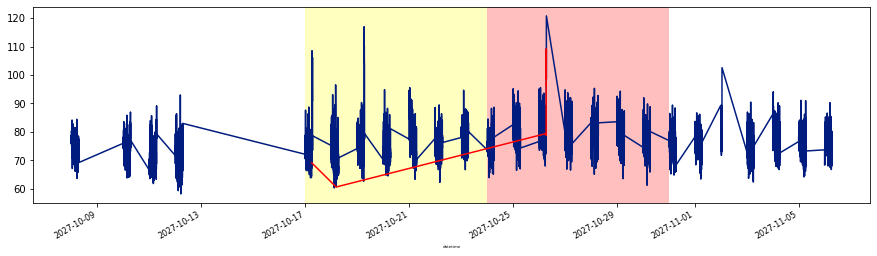

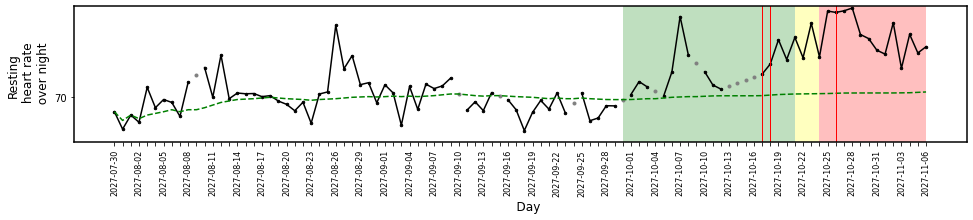

                      heartrate
datetime                       
2027-10-17 06:13:00   69.111111
2027-10-18 04:47:00   60.636364
2027-10-26 06:44:00   79.428571
2027-10-26 06:45:00   78.800000
2027-10-26 06:46:00   81.666667
2027-10-26 06:47:00   82.166667
2027-10-26 06:48:00   97.250000
2027-10-26 06:49:00   96.500000
2027-10-26 06:53:00  109.200000
2027-10-26 06:55:00   98.555556


In [8]:
df_subset = test.iloc[np.where(anomalies)]
fig, ax = plt.subplots()
fig.set_figwidth(15)

test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")

if(info['covid_test_date']!=None):
        plt.axvspan(info['covid_test_date'], min(test.index[-1], info['covid_test_date']+pd.to_timedelta('7d')), facecolor='red', alpha=0.25, label='Covid')
        plt.axvspan(info['covid_test_date'], max(test.index[1], info['covid_test_date']-pd.to_timedelta('7d')), facecolor='yellow', alpha=0.25, label='Covid')
plt.show()



dates = test.iloc[np.where(anomalies)].resample('1D').count().fillna(0).rename(columns={'heartrate': 'count'})

dates['alarm'] = (dates['count'] > 0)*2
# return dates
ali.ui.plot(rhr,alerts=dates,info=info,show=True)
print(test.iloc[np.where(anomalies)])